# Getting image insights with Google's Vision AI

## Overview

Given a folder full of images, we want a list of descriptions of each image – and we'll use an online service to get those descriptions.


## The Plan

Our steps will be:

1. Load some test images
1. Send one image to the Google Vision API
1. Dissect the response for that image
1. Send several images to the Google Vision API 
1. Generate a list of images and their contents

## Credits

The code in this notebook was written by John Keefe at [Quartz](https://qz.com).

## Setup

### Using an online service

Instead of downloading and using a pretrained model, as described in the notebook `bb-label-images-with-resnet.ipynb`, we can send each image to an online service to detect the contents. There are several available, and in this case we'll use [Google's Vision AI](https://cloud.google.com/vision/) service. 

These services generally allow you to try _some_ images for free, and then you must pay for any over that limit. As of this writing, Google Vision allows you to do 1,000 checks in a month for free. [The full price list is here](https://cloud.google.com/vision/pricing).

Because you _could_ go over the limit, Google requires a credit card on file before you may use this service – even if you're not yet over the free limit. 

In exchange, you get an API key, which looks like someone smashed away on a keyboard: `LKjldSLKfivvl384Ls0409Slootvj5ccrxcx4f45s567vvatyuw`

You need an API key to use this notebook! To get a key, follow the instructions in Video 5.

### For those using Google Colaboratory ...

Be aware that Google Colab instances are ephemeral -- they vanish *Poof* when you close them, or after a period of sitting idle (currently 90 minutes), or if you use one for more than 12 hours.

Also note that although we are using two Google services – Colaboratory and Vision AI – I'm treating them as completely separate. So we actually communicate between the two services the same way we would communicate from any computer to Vision AI.

### Everybody do this ...

Everyone needs to run the next cell, which installs and initializes the Python libraries we'll use in this notebook.

In [0]:
## *EVERYBODY* SHOULD RUN THIS CELL
!pip install Pillow --quiet
!pip install requests --quiet

import os
import json
import requests
import base64
from PIL import Image
from IPython.display import display
from IPython.display import Image as Show

### Your API key goes here

As mentioned above, you'll need to get an API key. Video 5 has the details on how to get that key from Google.

Once you have a key, replace `XXXXX` with your key in the next cell and run it.

In [0]:
# Replace the XXXXX in the next line with your API key (keep the quotes!):
YOUR_API_KEY = 'XXXX---..XXXX'

## The Data

We're going to download some data for this notebook:

- A folder containing some **pictures**. These are just pictures I took.

In [0]:
# Run this cell to download the data we'll use for this exercise
!wget -N https://qz-aistudio-public.s3.amazonaws.com/workshops/labelling_images_data.zip --quiet
!unzip -q labelling_images_data.zip
print('Done!')

In [0]:
data_path ='./data/'

In [0]:
# mount drive to work with
from google.colab import drive
drive.mount('/content/drive')

In [5]:
%cd /content/drive/'My Drive'/Colab_Notebooks/ml_journalists

/content/drive/My Drive/Colab_Notebooks/ml_journalists


We can look at the data on the computer we're using by using the `ls` command:

In [6]:
%ls data/

imagenet_class_index.json  images/


In [7]:
%ls data/images

antelope.jpg    drone.png     IMG_8040.JPG  ostrich.jpg  wrist_watch.jpg
bldg_block.png  IMG_1407.JPG  lioness.jpg   pen.jpg
boat2.jpg       IMG_8027.JPG  nanyuki.jpg   warthog.jpg


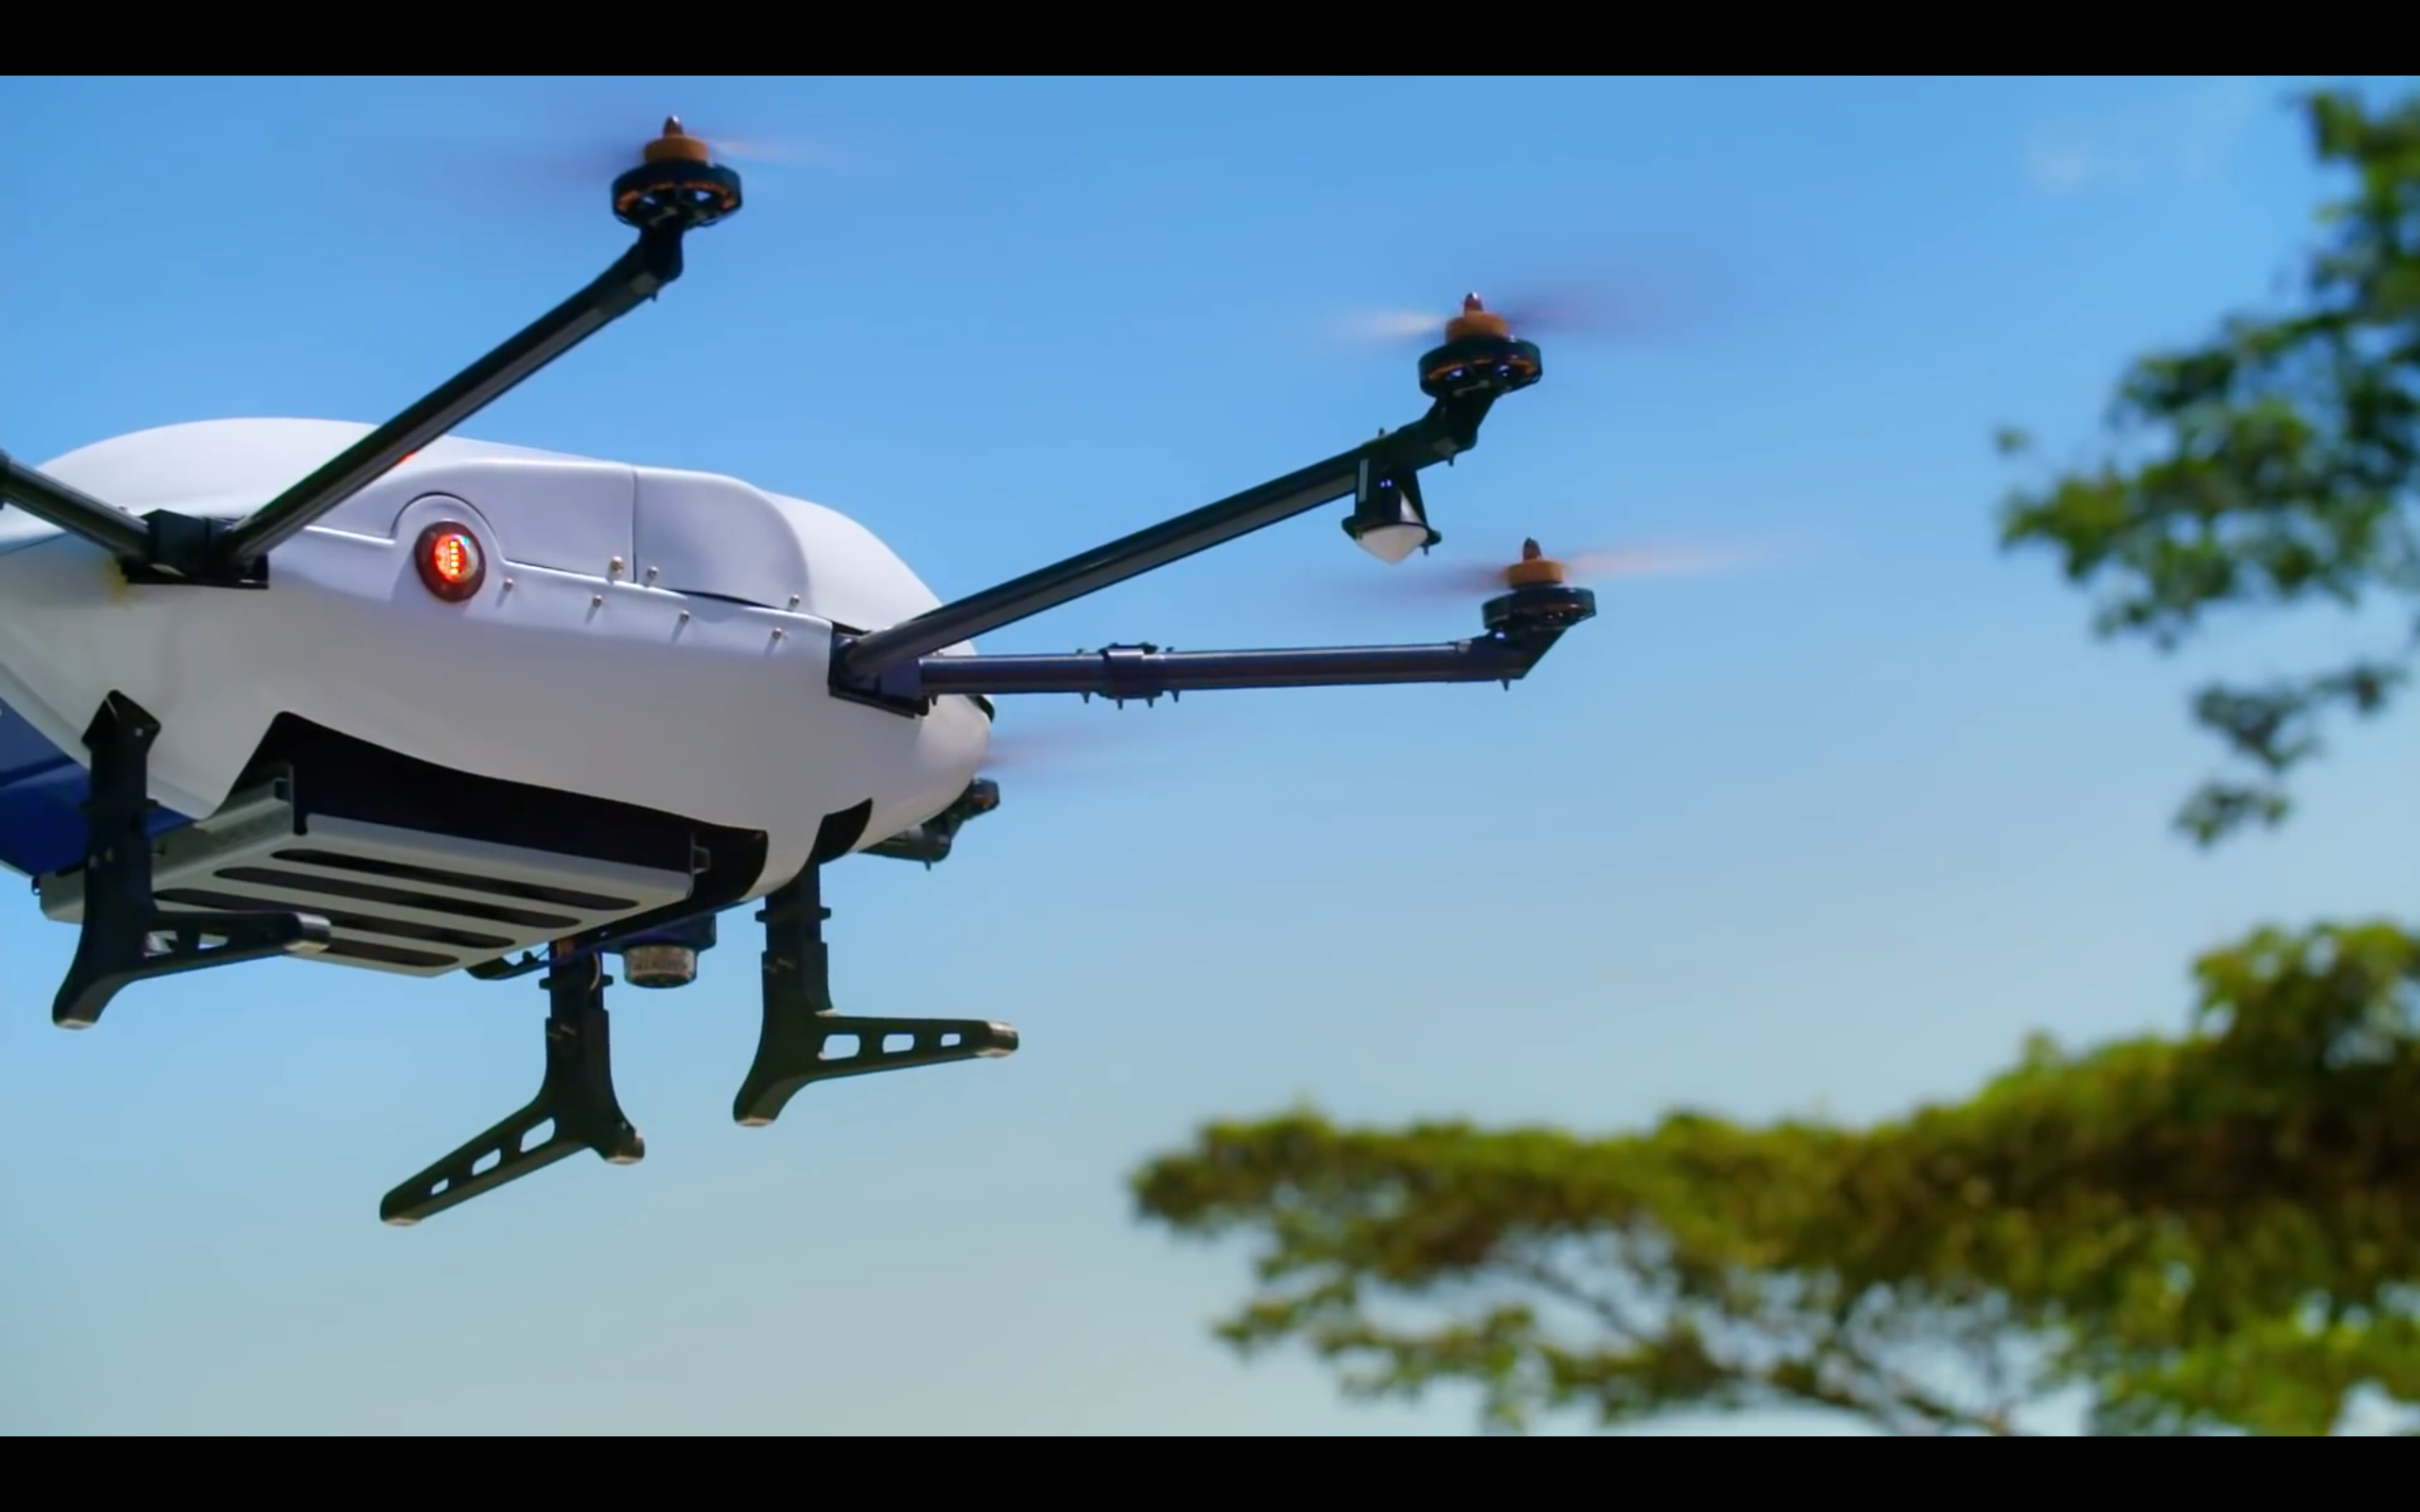

In [8]:
Show(data_path + 'images/drone.png', width=600)

In [0]:
# Here we open our boat file and convert it into image data text (called base-64-encoded text)
with open(data_path + 'images/drone.png', "rb") as my_image:
    my_image_data = str(base64.b64encode(my_image.read()).decode("utf-8"))

In [10]:
# Want to see what an image "looks" like in base-64 text???
my_image_data

'iVBORw0KGgoAAAANSUhEUgAACgAAAAZACAYAAAC1rBvAAAAMSGlDQ1BJQ0MgUHJvZmlsZQAASImVVwdYU8kWnltSSWiBCEgJvYlSpEsJoUUQkCrYCEkgocSQEETsLssquHYRARu6KqLoWgBZK+paF8HeH4qorKyLBRsqb1JgXfd7733vfN/c++fMOf8pmXvvDAA6NTypNBfVBSBPUiCLjwhhTUpNY5G6AAGggAwH4PHlUnZcXDSAMnT/u7y9ARDl/aqLkuuf8/9V9ARCOR8AJA7iDIGcnwfxQQDwEr5UVgAA0QfqrWcWSJV4CsQGMpggxFIlzlLjEiXOUONKlU1iPAfi3QCQaTyeLAsA7WaoZxXysyCP9i2IXSUCsQQAHTLEgXwRTwBxJMSj8vJmKDG0Aw4ZX/Fk/Y0zY5iTx8saxupaVEIOFculubxZ/2c7/rfk5SqGYtjBQRPJIuOVNcO+3cqZEaXENIh7JRkxsRDrQ/xeLFDZQ4xSRYrIJLU9asqXc2DPABNiVwEvNApiU4jDJbkx0Rp9RqY4nAsxXCFokbiAm6jxXSyUhyVoOGtkM+Jjh3CmjMPW+DbwZKq4SvvTipwktob/lkjIHeJ/UyxKTFHnjFELxckxEGtDzJTnJESpbTCbYhEnZshGpohX5m8DsZ9QEhGi5semZcrC4zX2sjz5UL3YYpGYG6PBVQWixEgNz24+T5W/EcTNQgk7aYhHKJ8UPVSLQBgapq4daxdKkjT1Yp3SgpB4je8raW6cxh6nCnMjlHoriE3lhQkaXzywAC5INT8eIy2IS1TniWdk88bHqfPBi0A04IBQwAIKODLADJANxG29Tb3wl3omHPCADGQBIXDRaIY8UlQzEnhNAMXgD4iEQD7sF6KaFYJCqP88rFVfXUCmarZQ5ZEDnkCcB6JALvytUHlJhqMlg8dQI/5HdD7MNRcO5dw/dWyoidZoFEO8LJ0hS2IYMZQYSQwnOuImeCDuj0fDazAc7rg

## Send our image to Google Vision AI

Next, we need construct a "payload" to send to Google Vision AI. [The format for building this payload is in the google documentation](https://cloud.google.com/vision/docs/request) if you'd like to read more. But we'll walk through a simple case now.

For our first payload, we'll send the image (as text) and a request for "LABEL_DETECTION."

In [0]:
# Establish the payload, which includes our image data as a long string of text
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'LABEL_DETECTION'
                },
            ]
        }
    ]
}

In [0]:
# Now we'll build the URL to hit, which includes your Google Vision API key.
google_vision_url = 'https://vision.googleapis.com/v1/images:annotate?key=' + YOUR_API_KEY

In [0]:
# And then we ship our boat (in the payload) to that URL
web_request = requests.post(google_vision_url, json=google_vision_payload)

The `web_request` now contains a lot of stuff in it. Let's pull it apart a little.

In [14]:
# This line lets us know how hitting Google Vision AI worked. Code "200" is what we want
web_request.status_code

200

Let's take a look at what we got from Google.

In [0]:
google_guess = web_request.json() # turns the web_request into JSON
google_guess['responses']         # let's look at the "responses" part

KeyError: ignored

In [0]:
google_guess['responses'][0]['labelAnnotations']

KeyError: ignored

In [0]:
google_guess['responses'][0]['labelAnnotations'][0]

In [0]:
google_guess['responses'][0]['labelAnnotations'][0]['description']

We can also ask for a different features, such as [text detection](https://cloud.google.com/vision/docs/ocr). (Note that there's a different version to use if you're looking for [text in images of documents](https://cloud.google.com/vision/docs/ocr).

In [0]:
# Again, we build the payload but use "TEXT_DETECTION" instead ...
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'TEXT_DETECTION'
                }
            ]
        }
    ]
}

In [0]:
# And we hit the URL we provided above, but with this new payload
web_request = requests.post(google_vision_url, json=google_vision_payload)

In [0]:
web_request.status_code

In [0]:
google_guess = web_request.json()

In [0]:
google_guess['responses'][0]['textAnnotations']

In [0]:
google_guess['responses'][0]['fullTextAnnotation']['text']

We can also ask for what Google calls "[web detection](https://cloud.google.com/vision/docs/detecting-web)", which pulls information from it's vast knowledge of the internet to try to get more information about the image.

In [0]:
# Here we'll ask for "WEB_DETECTION" and just one result ('maxResults':1)
google_vision_payload = {
    'requests':[
        {
            'image':{
                'content': my_image_data
            },
            'features':[
                {
                    'type':'WEB_DETECTION',
                    'maxResults':1
                },
            ]
        }
    ]
}

In [0]:
# And we hit the URL we provided above, but with this new payload
web_request = requests.post(google_vision_url, json=google_vision_payload)
google_guess = web_request.json()

In [0]:
google_guess['responses'][0]

In [0]:
google_guess['responses'][0]['webDetection']['webEntities'][0]['description']

## Processing a set of images

Let's get some images! (Pretend there are 8,000 instead of 8.)

In [0]:
image_files = os.listdir(data_path + 'images')
image_files

In [0]:
# Loop through the list of files

category_list=[]

for file in image_files:
    
    # open a file and convert it into image data text
    with open(data_path + 'images/' + file, "rb") as my_image:
        my_image_data = str(base64.b64encode(my_image.read()).decode("utf-8"))
        
    # set up the google vision payload, including the image data text
    google_vision_payload = {
        'requests':[
            {
                'image':{
                    'content': my_image_data
                },
                'features':[
                    {
                        'type':'WEB_DETECTION',
                        'maxResults':1
                    },
                ]
            }
        ]
    }
    
    # hit the google vision api
    web_request = requests.post(google_vision_url, json=google_vision_payload)
    google_guess = web_request.json()
    
    # from the goole response, pull out the webEntity description 
    category = google_guess['responses'][0]['webDetection']['webEntities'][0]['description']
    
    # add this category to the category list
    category_list.append(category)
    
    # print the file name and the category guess
    print(file, category)
    

In [0]:
# let's loop through all the images we have and display the
# category Google thinks it falls into

for i, file in enumerate(image_files):
  image_filename = data_path + 'images/' + file
  print(f'\n{category_list[i]}')
  display(Show(filename=image_filename, retina=True))

### Extra Challenge

Even more useful would be to save this list as a file! If you're comfortable with Python, you should be able to pull that off pretty easily.

## Google Vision Pricing

You can get categories for 1,000 images for free and 10,000 images for $15.00. [Check out the pricing info](https://cloud.google.com/vision/pricing).